In [185]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns, breathing_signal as breath

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'

from scipy.optimize import curve_fit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **One session exploration**

In [186]:
def parse_user_date(user_date_str):
    """
    Parses a user-provided date string in the format 'YYYY-MM-DD' and returns a datetime.date object.

    Parameters:
    user_date_str (str): A string representing a date in the format 'YYYY-MM-DD'.

    Returns:
    datetime.date: The parsed date if the format is valid.
    None: If the input format is incorrect.
    """
    try:
        return datetime.strptime(user_date_str, "%Y-%m-%d").date()  # Convert user input to date
    except ValueError:
        return None

def extract_and_convert_time(filename):
    """
    Extracts a timestamp from a filename and converts it to a local date in the 'America/Los_Angeles' timezone.

    The filename must follow one of these formats:
    - 'prefix_YYYY-MM-DDTHHMMSSZ_suffix' (UTC timestamp, indicated by 'Z')
    - 'prefix_YYYYMMDDTHHMMSS_suffix' (Local time in 'America/Los_Angeles')

    Parameters:
    filename (str): A string containing a timestamp in one of the expected formats.

    Returns:
    datetime.date: The extracted and converted local date.
    str: "Invalid filename format" if the filename format does not match expectations.
    """
    seattle_tz = pytz.timezone('America/Los_Angeles')

    # Extract the timestamp part
    timestamp_part = filename.split("_")[1]

    try:
        if "Z" in timestamp_part:  # Case: UTC timestamp
            dt_utc = datetime.strptime(timestamp_part, "%Y-%m-%dT%H%M%SZ")
            dt_local = dt_utc.replace(tzinfo=pytz.utc).astimezone(seattle_tz)
        else:  # Case: Already local time
            dt_local = datetime.strptime(timestamp_part, "%Y%m%dT%H%M%S")
            dt_local = seattle_tz.localize(dt_local)
        return dt_local.date()
    except ValueError:
        return "Invalid filename format"


In [187]:
date_string = "2025-03-14"
date = parse_user_date(date_string)
mouse = '754580'

In [224]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))
sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# All this segment is to find the correct session without having the specific path
for file_name in sorted_files:
    
    if session_found == True:
        break
    
    session = extract_and_convert_time(file_name)
    if session != date:
        continue
    else:
        print(str(session), file_name)
        session_found = True
        
    # Recover data streams
    session_path = os.path.join(base_path, mouse, file_name)
    session_path = Path(session_path)
    data = parse.load_session_data(session_path)
    rig_name = data['config'].streams.rig_input.data['rig_name']
    
    # Parse data into a dataframe with the main features
    all_epochs = parse.parse_dataframe(data)
    # -- At this step you can save the data into a csv file
    
    # Expand with extra columns
    extra_columns = AddExtraColumns(all_epochs, run_on_init=True)
    all_epochs = extra_columns.all_epochs
    reward_sites = extra_columns.reward_sites

    # Load the encoder data separately
    stream_data = parse.ContinuousData(data)
    encoder_data = stream_data.encoder_data
    odor_triggers = stream_data.odor_triggers

if session_found == False:
    print('Session not found')

2025-03-14 754580_2025-03-14T224719Z


In [225]:
reward_sites.columns

Index(['label', 'start_position', 'length', 'friction', 'active_patch',
       'patch_label', 'odor_label', 'visit_number', 'END', 'stop_cue',
       'water_onset', 'succesful_wait', 'has_choice', 'reward_delivered',
       'reward_amount', 'reward_probability', 'reward_available',
       'total_sites', 'previous_interpatch', 'previous_intersite',
       'same_patch', 'skipped_count'],
      dtype='object')

In [190]:
# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']
    
label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}

In [194]:
# Summary of different relevants aspects -------------------------------------------------

unrewarded_stops = reward_sites.loc[reward_sites.reward_delivered==0]['has_choice'].count()
rewarded_stops = reward_sites.loc[reward_sites.reward_delivered==1]['has_choice'].count()
water_collected = reward_sites.loc[(reward_sites['reward_delivered']==1)]['reward_amount'].sum()
total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

# Rewarded stops / total available rewarded stops
optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

# Rewarded stops / Stops
efficiency = rewarded_stops / reward_sites.reward_delivered.sum()

print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

if 'startPosition' in all_epochs.columns:
    stop_duration = np.round(all_epochs.startPosition.max()/100,2)
else:
    stop_duration = np.round(all_epochs.start_position.max()/100,2)
print('Total travelled m: ', np.round(all_epochs.start_position.max()/100,2))

for odor_label in reward_sites.odor_label.unique():
    values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['reward_delivered']==1)]['has_choice'].sum()
    print(f'{odor_label} {values} ul')

Total sites:  157  |  Total rewarded stops:  18 ( 13.04 %) |  Total unrewarded stops:  139 ( 100.72 %) |  Water consumed:  90.0 ul
Total travelled m:  237.44
Fenchone 12.0 ul
Alpha-pinene 6.0 ul
Amyl Acetate 0.0 ul


In [198]:
reward_sites.groupby('odor_label')['patch_label'].unique()

odor_label
Alpha-pinene      [delayed]
Amyl Acetate    [no_reward]
Fenchone           [single]
Name: patch_label, dtype: object

In [199]:
software_tone = data['software_events'].streams['ChoiceFeedback'].data.index
choice_tone = stream_data.choice_feedback.index

In [200]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(1,1, figsize=(20,4))
    
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    software_tone = data['software_events'].streams['ChoiceFeedback'].data.index
    _legend["SoftTone"] = axs.scatter(software_tone - zero_index,
            software_tone*0 + y_idx,
            marker=".", s=s, lw=lw, c='green',
            label="SoftwareTone")
    
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    
    
    software_water = data['software_events'].streams['GiveReward'].data.index
    _legend["SoftReward"] = axs.scatter(software_water - zero_index,
            software_water*0 + y_idx,
            marker="x", s=s, lw=lw, c='red',
            label="SoftwareReward")
    
    _legend["Licks"] = axs.scatter(stream_data.lick_onset - zero_index,
        stream_data.lick_onset*0 + 1,
        marker="|", s=s, lw=lw, c='black',
        label="Lick")
    
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    _legend["Odor_on"] = axs.scatter(odor_triggers.odor_onset - zero_index,
        odor_triggers.odor_onset*0 + 2.5,
        marker="|", s=s, lw=lw, c='pink',
        label="ON")
    
    _legend["Odor_off"] = axs.scatter(odor_triggers.odor_offset - zero_index,
        odor_triggers.odor_offset*0 + 2.5,
        marker="|", s=s, lw=lw, c='purple',
        label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    ax2.hlines(0, 0, active_site.index[-1] - zero_index, lw=1)
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 20])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 20

def on_right_button_clicked(button):
    x_start_widget.value += 20

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

In [201]:
def add_position(df: pd.DataFrame, position:  pd.DataFrame):
    
    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

In [ ]:
def update_plot(x_start):
    zero_index = active_site.index[0]
    
    # Start plotting raster
    position = data['operation_control'].streams.CurrentPosition.data
    position.rename_axis('Time', axis='index', inplace=True)
    active_site.rename_axis('Time', axis='index', inplace=True)

    fig, ax = plt.subplots(figsize=(20,4))
    _legend = {}

    _sites = add_position(active_site, position=position)

    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (_sites["Position"].iloc[idx], -2), _sites["Position"].iloc[idx+1] - _sites["Position"].iloc[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = 0.5 )
        _legend[site_label] = p
        ax.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = 0
    _legend["ChoiceFeedback"] = ax.scatter(add_position(stream_data.choice_feedback, position=position)["Position"].values,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker=".", s=s, lw=lw, c='#e6ab02',
            label="ChoiceFeedback")
    y_idx += 1
    _legend["Lick"] = ax.scatter(add_position(stream_data.lick_onset, position=position)["Position"].values,
               stream_data.lick_onset.index * 0 + y_idx,
               marker="|", s=s, lw=lw, c='k',
               label="Lick")
    
    odor_triggers.index = odor_triggers.odor_onset
    odor_triggers.rename_axis('Time', axis='index', inplace=True)
    _legend["Odor_on"] = ax.scatter(add_position(odor_triggers.odor_onset, position=position)["Position"].values,
        odor_triggers.odor_onset*0 + 2.5,
        marker="|", s=s, lw=lw, c='pink',
        label="ON")

    odor_triggers.index = odor_triggers.odor_offset
    odor_triggers.rename_axis('Time', axis='index', inplace=True)
    _legend["Odor_off"] = ax.scatter(add_position(odor_triggers.odor_offset, position=position)["Position"].values,
        odor_triggers.odor_offset*0 + 1.5,
        marker="|", s=s, lw=lw, c='purple',
        label="OFF")
    
    _legend["ValveOpen"] = ax.scatter(add_position(stream_data.give_reward, position=position)["Position"].values,
               stream_data.give_reward.index*0 + y_idx,
               marker=".", s=s, lw=lw, c='cyan',
               label="ValveOpen")
    y_idx += 1

    ax.set_yticklabels([])
    ax.set_xlabel("VrSpace(cm)")
    ax.grid(False)
    ax.set_ylim(bottom=-1, top = 4)
    ax.set_yticks([0,3])
    ax.yaxis.tick_right()
    ax.set_xlim([x_start, x_start + 500])
    # ax.set_xlim(_sites.loc[(_sites.index - zero_index > win[0]) & (_sites.index - zero_index < win[1]), :]["Position"].values[[0, -1]])
    ax.grid(False)

    ax2 = ax.twinx()
    _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=position)["Position"].values, stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    # v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    # _legend["Velocity_Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 50))
    ax2.set_ylabel("Velocity (cm/s)")
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 250

def on_right_button_clicked(button):
    x_start_widget.value += 250

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

4B


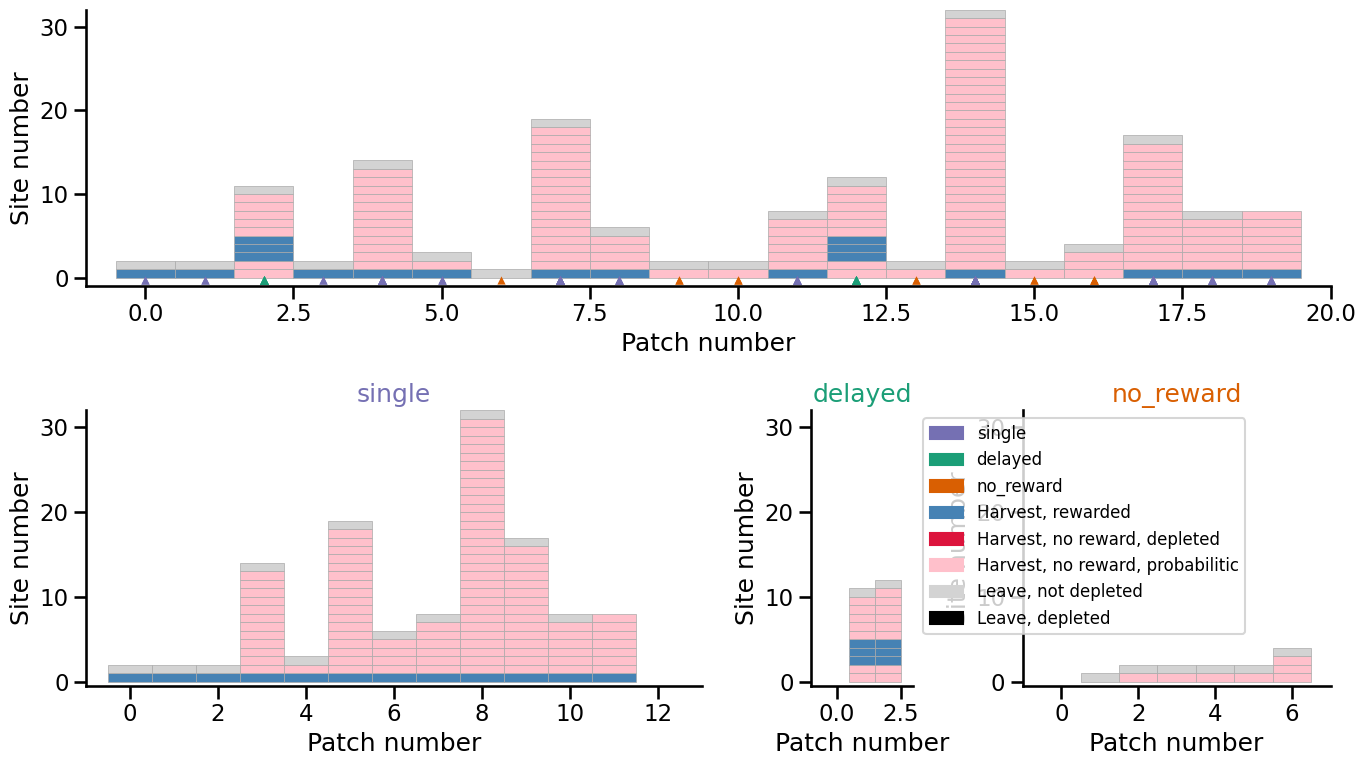

In [204]:
print(rig_name)
all_epochs['odor_label'] = all_epochs['patch_label']
plotting.segmented_raster_vertical(all_epochs.loc[all_epochs['label'] == 'RewardSite'], 
                                data['config'], 
                                color_dict_label=color_dict_label)

### Segments of the session in patches

Same as above but plotting only one patch at a time

In [208]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    start = active_site.loc[active_site['active_patch']==x_start].index[0] - zero_index
    stop = active_site.loc[active_site['active_patch']==x_start+1].index[1] - zero_index
    
    fig, axs = plt.subplots(1,1, figsize=(20,4))
    plt.title('Patch: ' + str(x_start))
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]

    # _legend["Velocity_2"] = ax2.plot(sensor_data.index - zero_index, sensor_data['velocity'], c="blue", label="Encoder_2", alpha = 0.8)[0]
     
    # _legend["Velocity"] = ax2.plot(sensor_data_filter.index - zero_index, sensor_data_filter.filtered_velocity, c="red", label="Encoder", alpha = 0.8)[0]
    
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([start, stop])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [209]:
breathing_data = processing.fir_filter(stream_data.breathing, 'data', 100)

In [211]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2,1, figsize=(8,8), gridspec_kw={'height_ratios': [2, 3]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(breathing_data.index - zero_index, breathing_data.filtered_data.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0]+100, stream_data.breathing.mean()[0]-100)
    ax3.set_ylabel("Breathing (au)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.08, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 15])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 5

def on_right_button_clicked(button):
    x_start_widget.value += 5

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

Output()

### **Detailed plots**
With the dataframe reward_sites you can explore different aspects of the behavior. You can for instance use it to align velocity traces and look at how they might be different for different odors. 

In [212]:
encoder_data = parse.ContinuousData(data).encoder_loading(parser='filter')

In [216]:
trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse, session, window=(-2,4))
plotting.velocity_traces_odor_entry(trial_summary, max_range=max(trial_summary.speed.values), color_dict_label=color_dict_label, mean=True, save=False, window=(-2,4))

KeyError: "['odor_sites'] not in index"

Look at a summary of the session plotting each patch and site and look at whether they were rewarded or not

In [ ]:
summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})

patch_number = len(reward_sites.active_patch.unique())
number_odors = len(reward_sites['odor_label'].unique())
list_odors = []
for odor in reward_sites.odor_label.unique():
    list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
grid = (np.array(list_odors)/patch_number)*number_odors

fig, ax = plt.subplots(2,1, figsize=(12, 10), sharex=True)

for index, row in reward_sites.iterrows():
    if row['reward_delivered'] == 1 and row['has_choice'] == True:
        color='steelblue'
    elif row['reward_delivered'] == 0 and row['has_choice'] == True:
        color='pink'
        if row['reward_available'] == 0:
            color='crimson'
    else:
        if  row['reward_available'] == 0:
            color='black'
            hatch = '/'
        else:
            color='lightgrey'
        
    ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
    ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
    ax[0].set_xlim(-1,50)
    ax[0].set_xlabel('Patch number')
    ax[0].set_ylabel('Site number')
    
    if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
        patch_color=odor_list_color[0]
    elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
        patch_color=odor_list_color[1]
    else:
        patch_color=odor_list_color[2]
    
    # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
    ax[0].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)
    ax[1].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)

odors = []
for index, odor in enumerate(reward_sites['odor_label'].unique()):
    odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
label_4 = mpatches.Patch(color='lightgrey', label='Leave')

odors.extend([label_2, label_3,label_4])
plt.legend(handles=odors, loc='lower right', bbox_to_anchor=(0.5, -0.65), fontsize=12, ncol=2)
ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
summary.reset_index(inplace=True)

sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None)
sns.barplot(x='active_patch', y='reward_delivered', data=summary, ax=ax[1], errorbar=None)

# Specifying the number of xticks
num_ticks = 10  # Change this to the desired number of ticks
xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

# Specifying the xticks
ax[1].set_xticks(xticks)
# ax[1].set_xlim(-1,125)
ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
ax[1].set_ylabel('Site number')
ax[1].set_xlabel('Patch number')
sns.despine()

# fig.savefig(foraging_figures+f'/raster_plot_example_{mouse}_{date}.svg', dpi=300, bbox_inches='tight')

Explore if animals experienced a decaying curve close to the theoretical one

In [ ]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

summary = reward_sites.loc[reward_sites.has_choice==True].groupby(['cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)

summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14, 5))
i = 0
for odor in dict_odor.keys():
    odor_df = summary.loc[summary['odor_label'] == odor]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if odor_df.empty:
        continue
    
    sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(processing.exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
        ax[i].plot(x_values, processing.exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, processing.exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_ylabel('Percent collected')
    ax[i].set_xlabel('Cumulative rewards')
    plt.tight_layout()
    sns.despine()
    i += 1

In [ ]:
plotting.preward_estimates(reward_sites, color_dict_label = color_dict_label)